In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample
from astropy.io import fits

import optimusprimal.primal_dual as primal_dual
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

import optimusprimal as optpr
import ProxNest as prn
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

In [2]:
# Auxiliary functions

def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)



First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [3]:
options = {"tol": 1e-4, "iter": 5000, "update_iter": 50, "record_iters": False}

## Load image

INSTRUME                                                                         [astropy.io.fits.card]


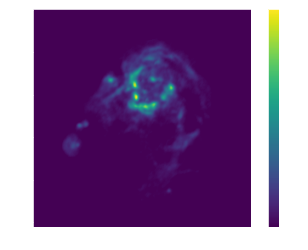

In [21]:
img_path = './../data/imgs/M31.fits'

img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img
 
plt.figure()
plt.imshow(img);plt.colorbar()
plt.show()


## Prepare the inverse problem setup

In [5]:
dim = img.shape[0]

# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)

# Simulate mock noisy observations y
y = phi.dir_op(img)
ISNR = 25
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)


rng = np.random.default_rng(seed=0)

n = rng.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n



## CRR-based UQ

### Compute the MAP


In [6]:
import torch
from convex_reg import utils
from tqdm import tqdm

gpu = False

if gpu:
    device = 'cuda:0'
    torch.set_grad_enabled(False)
    torch.set_num_threads(4)
else:
    device = 'cpu'
    

In [7]:
sigma_training = 25
t = 5
dir_name = '/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t}/'
model = utils.load_model(dir_name+exp_name, device, gpu=gpu)

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [8]:

myType = torch.float32

# y_torch = torch.tensor(y, device=device, dtype=myType, requires_grad=False).reshape((1,1) + y.shape) # .to(torch.float32)
x_torch = torch.tensor(x.copy(), device=device, dtype=myType, requires_grad=False).reshape((1,1) + x.shape) 

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None


In [9]:
# Gradient descent

# phi.adj_op()
# phi.dir_op()

x_init = np.real(phi.adj_op(y))
x_init_torch = torch.tensor(x_init, device=device, dtype=myType, requires_grad=False).reshape((1,1) + x_init.shape) 

# optimization settings
tol = 1e-4
n_iter_max = 1500
lmbd = 3 # 4.5 # 6
mu = 20

# stepsize rule
L = model.L
alpha = 1. / ( 1. + g.beta + mu * lmbd * L)

# initialization
x_hat = torch.clone(x_init_torch)
z = torch.clone(x_init_torch)
t = 1


In [10]:
for i in tqdm(range(options['iter'])):
    x_hat_old = torch.clone(x_hat)
    # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
    x_hat = z - alpha *(torch.tensor(g.grad(z.detach().cpu().squeeze()), device=device, dtype=myType).reshape((1,1) + x_init.shape) + lmbd * model(mu * z))
    x_hat =  torch.real(x_hat)
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + np.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()
    if res < tol:
        break


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-10-fd08ec712d45>:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/Copy.cpp:250.)
  x_hat = z - alpha *(torch.tensor(g.grad(z.detach().cpu().squeeze()), device=device, dtype=myType).reshape((1,1) + x_init.shape) + lmbd * model(mu * z))
 17%|█▋        | 871/5000 [01:30<07:09,  9.62it/s]


/Users/tliaudat/miniconda3/envs/convex_uq/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


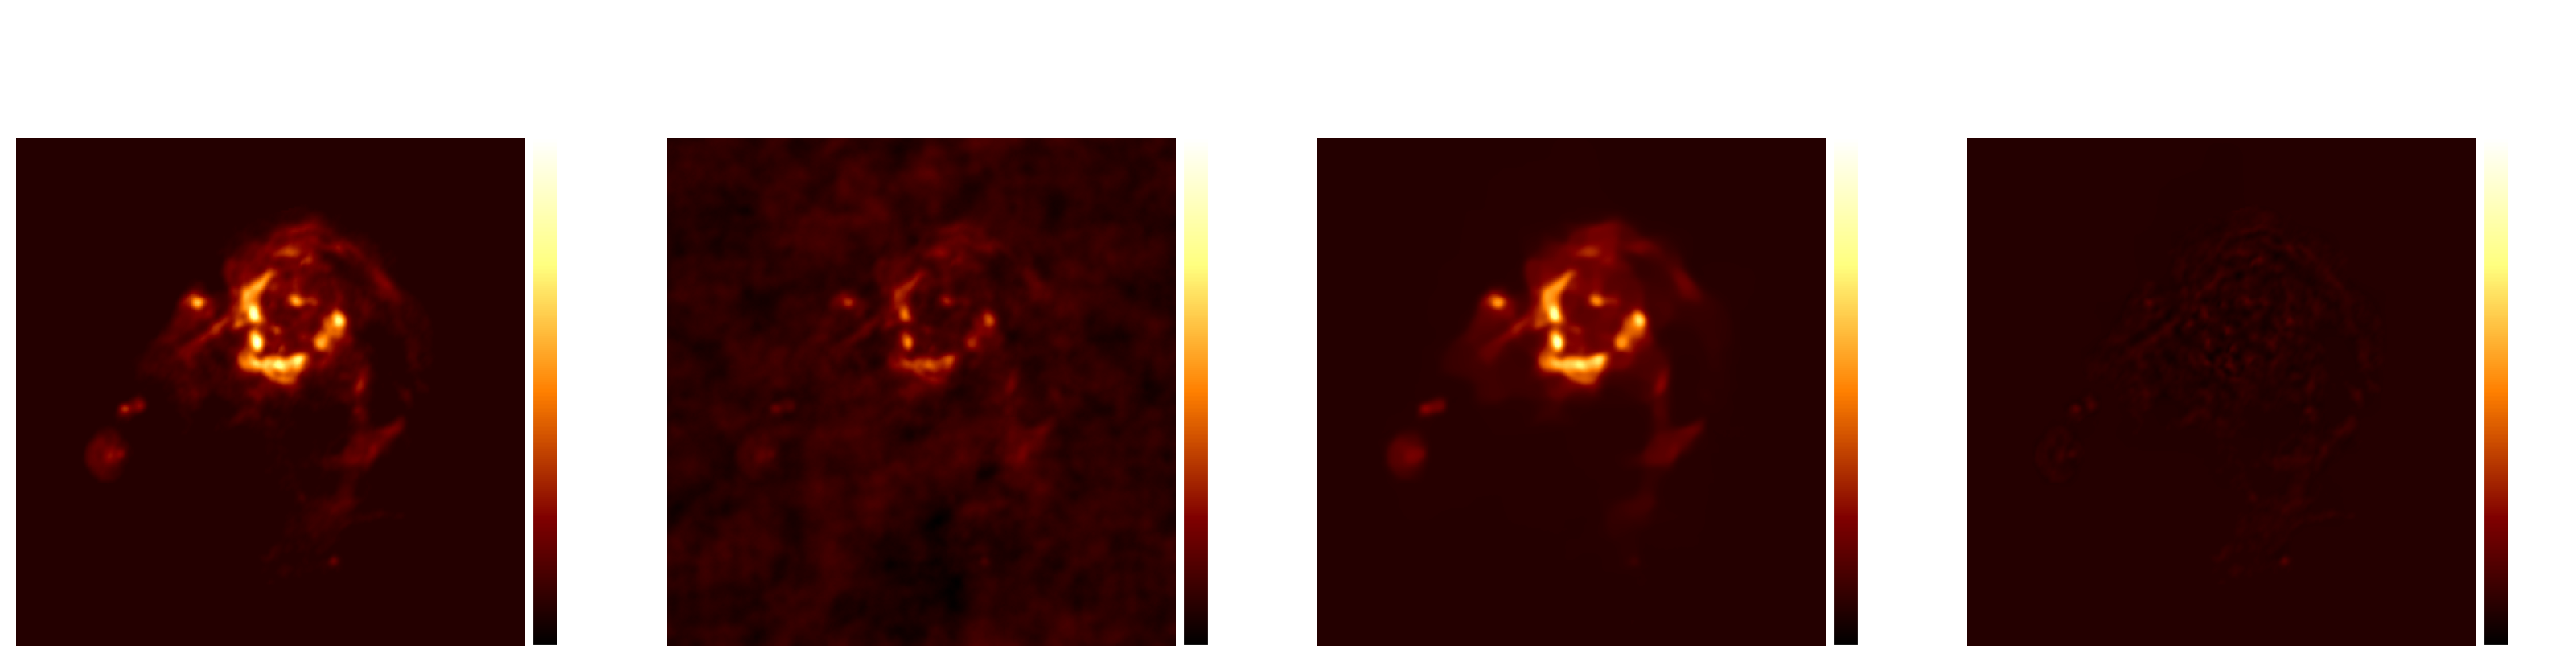

In [26]:
x_hat_np = x_hat.detach().cpu().squeeze().numpy()

images = [x, x_init, x_hat_np, x-np.abs(x_hat_np)]
images_torch = [x_torch, x_init_torch, x_hat, x_torch-x_hat]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(mu * images_torch[i])[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i]),
            model.cost(mu * images_torch[i])[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()

### Compute HPD region

In [28]:
alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

prior_fun = lambda model, x_hat, mu, lambda_param : (lambda_param/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False))

# gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N

gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N


loss_fun = lambda x_map : g.fun(x_map) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy()


In [32]:

print(
    'f(x_map): ', g.fun(x_hat_np),
    '\ng(x_map): ', (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy(),
    '\ntau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    '\nN: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  59468.11000318353 
g(x_map):  4.127827262878418 
tau_alpha*np.sqrt(N):  2445.577521189034 
N:  65536
N:  65536
tau_alpha:  9.553037192144664
gamma_alpha:  127453.81535163545


In [33]:
if dim==256:

    error_p_40, error_m_40, mean_40 = optpr.map_uncertainty.create_local_credible_interval(
        x_sol=x_hat_np,
        region_size=40,
        function=loss_fun,
        bound=gamma_alpha,
        iters=200,
        tol=1e-4,
        bottom=-1.,
        top=2.,
    )
    error_length_40 = error_p_40 - error_m_40

2023-02-15 19:46:09,815 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-15 19:46:22,786 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.059018859756179154, 0.057579553220421076) with sum -0.39503816
2023-02-15 19:46:33,339 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.05945931700989604, 0.057144776452332735) with sum -0.28224763
2023-02-15 19:46:44,373 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.05670529743656516, 0.0597611119155772) with sum 3.1395335
2023-02-15 19:46:55,460 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.05463482683990151, 0.06149722670670599) with sum 4.5775566
2023-02-15 19:47:09,204 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.0577345818746835, 0.05885810643667355) with sum 0.5102409
2023-02-15 19:47:20,790 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.05827378743560985, 0.0583126

In [38]:

error_p_30, error_m_30, mean_30 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=30,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1,
    top=2,
)
error_length_30 = error_p_30 - error_m_30



2023-02-15 19:56:23,312 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-15 19:56:36,445 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.0761552401818335, 0.07550177886150777) with sum -0.14239283
2023-02-15 19:56:48,126 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.07668448728509247, 0.07497697195503861) with sum -0.26558402
2023-02-15 19:56:59,450 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.07743752258829772, 0.0742204237030819) with sum -0.044405088
2023-02-15 19:57:10,408 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.07412151782773435, 0.07747374707832932) with sum 1.6774216
2023-02-15 19:57:21,208 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.07089351757895201, 0.0806095473235473) with sum 2.4904659
2023-02-15 19:57:32,066 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.07624783588107675, 0.07540273

In [39]:
error_p_20, error_m_20, mean_20 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=20,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1,
    top=2,
)
error_length_20 = error_p_20 - error_m_20

2023-02-15 20:06:24,451 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-15 20:06:37,145 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.11320579540915787, 0.11051678552757949) with sum -0.04569947
2023-02-15 20:06:48,211 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.11183442629408091, 0.11187068384606391) with sum -0.08162779
2023-02-15 20:06:59,279 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.11262698261998594, 0.11108207050710917) with sum -0.108522
2023-02-15 20:07:10,417 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.11473606573417783, 0.10902358451858163) with sum -0.13069794
2023-02-15 20:07:21,042 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.11287897289730608, 0.11081966396886855) with sum 0.13198578
2023-02-15 20:07:31,342 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.11115503613837063, 0.11253

In [42]:
error_p_10, error_m_10, mean_10 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=10,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1,
    top=2,
)
error_length_10 = error_p_10 - error_m_10

2023-02-15 20:34:33,876 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-15 20:34:45,933 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.22517374297603965, 0.22024477599188685) with sum -0.010392214
2023-02-15 20:34:57,533 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.2232049060985446, 0.22218997380696237) with sum -0.0067237257
2023-02-15 20:35:09,136 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.21951913181692362, 0.22592088882811368) with sum -0.0054159206
2023-02-15 20:35:19,848 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.2256203095894307, 0.21980382781475782) with sum -0.021601923
2023-02-15 20:35:30,449 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.22379231033846736, 0.22160571720451117) with sum -0.020909714
2023-02-15 20:35:41,154 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.21997836488299072,

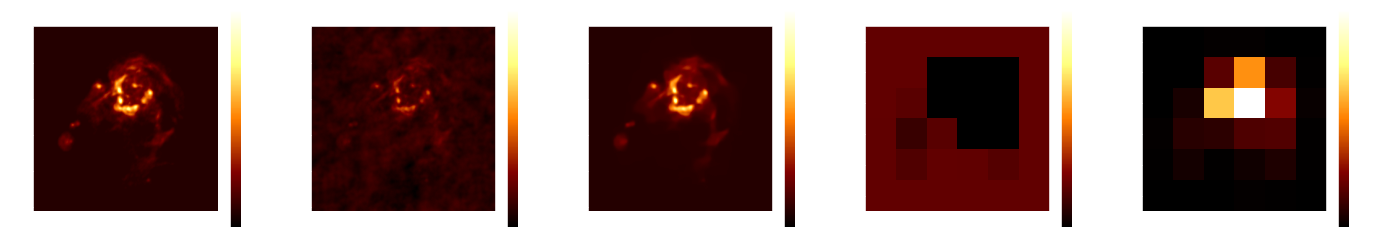

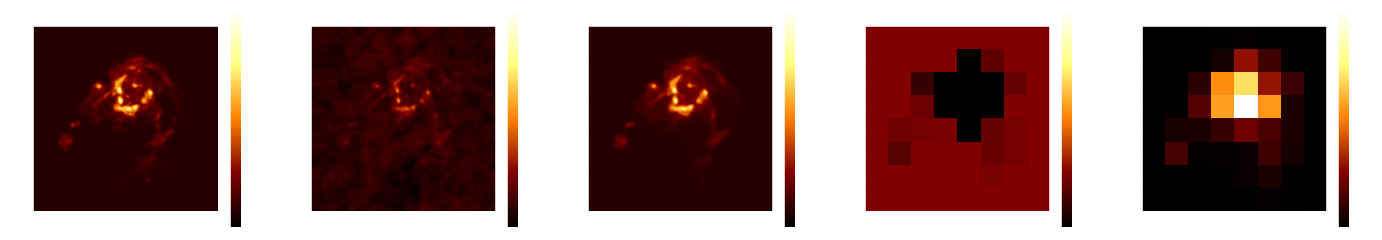

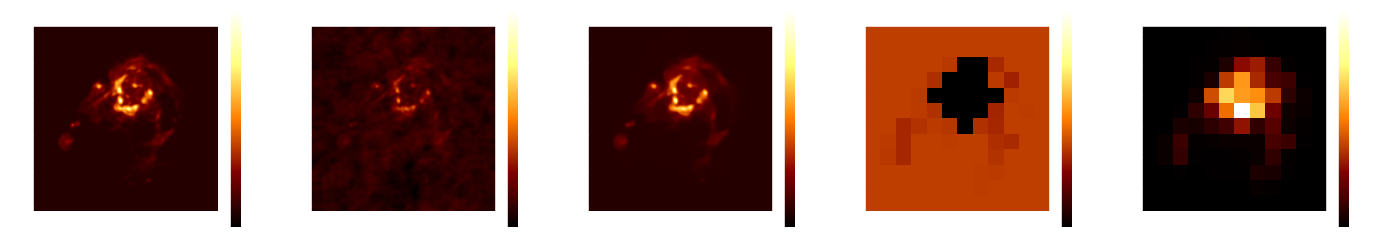

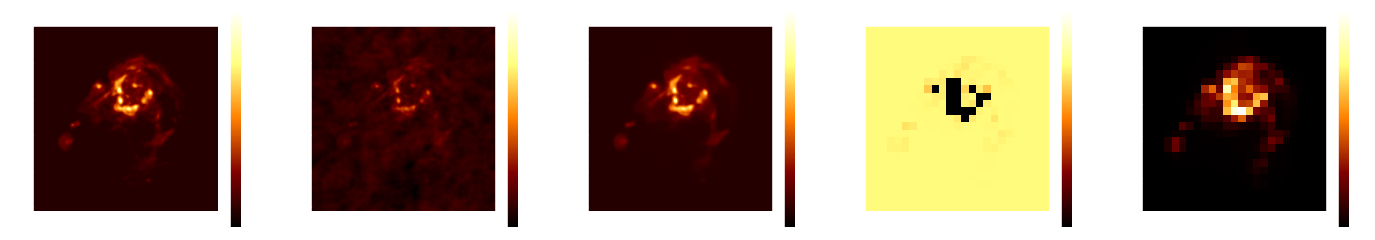

In [45]:
if dim==256:
    vmin = np.min((x, x_init, x_hat_np))
    vmax = np.max((x, x_init, x_hat_np))
    err_vmax= 0.6

    plt.figure(figsize=(24,4))
    plt.subplot(151)
    plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
    plt.subplot(152)
    plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
    plt.subplot(153)
    plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
    plt.subplot(154)
    plt.imshow(error_length_40, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
    plt.subplot(155)
    plt.imshow(mean_40, cmap='afmhot');plt.colorbar();plt.title('Mean')
    plt.savefig('./figs/M31_256_CCR-reg_superpix_40.pdf')
    plt.show()

    plt.figure(figsize=(24,4))
    plt.subplot(151)
    plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
    plt.subplot(152)
    plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
    plt.subplot(153)
    plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
    plt.subplot(154)
    plt.imshow(error_length_30, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
    plt.subplot(155)
    plt.imshow(mean_30, cmap='afmhot');plt.colorbar();plt.title('Mean')
    plt.savefig('./figs/M31_256_CCR-reg_superpix_30.pdf')
    plt.show()

    plt.figure(figsize=(24,4))
    plt.subplot(151)
    plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
    plt.subplot(152)
    plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
    plt.subplot(153)
    plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
    plt.subplot(154)
    plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
    plt.subplot(155)
    plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
    plt.savefig('./figs/M31_256_CCR-reg_superpix_20.pdf')
    plt.show()

    plt.figure(figsize=(24,4))
    plt.subplot(151)
    plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
    plt.subplot(152)
    plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
    plt.subplot(153)
    plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
    plt.subplot(154)
    plt.imshow(error_length_10, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
    plt.subplot(155)
    plt.imshow(mean_10, cmap='afmhot');plt.colorbar();plt.title('Mean')
    plt.savefig('./figs/M31_256_CCR-reg_superpix_10.pdf')
    plt.show()


In [118]:
x.shape

(64, 64)

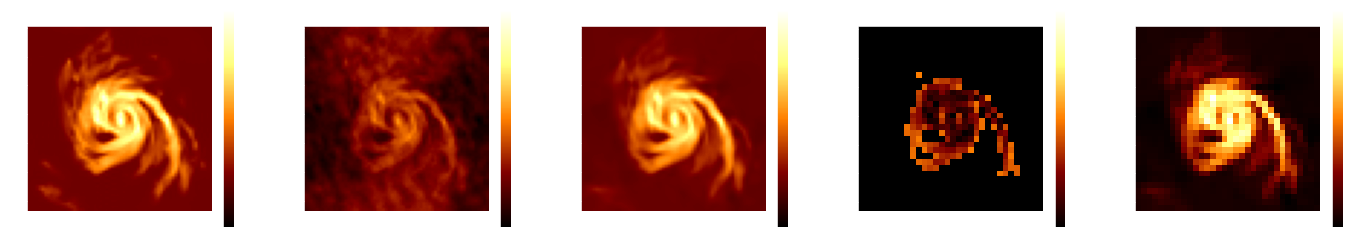

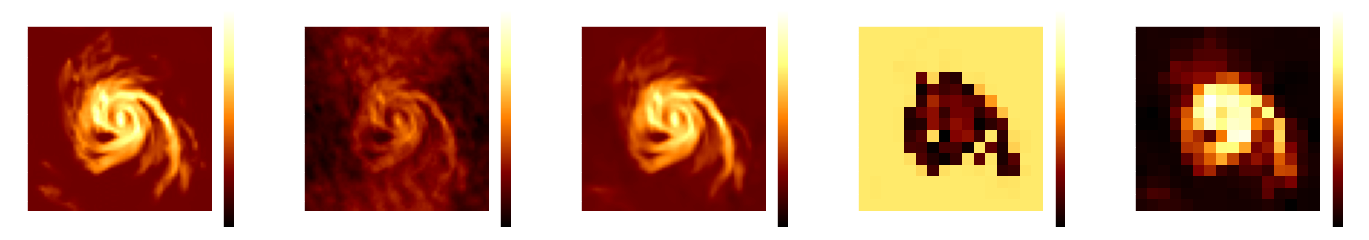

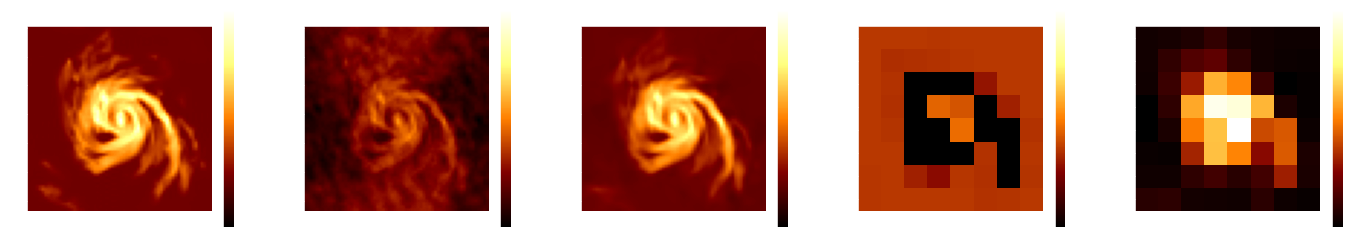

In [24]:

vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_2, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_2, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_2_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_4, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_4, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_4_range_05_-05.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_8, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_8, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_8_range_05_-05.pdf')
plt.show()

